# Chargement des packages

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgb
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
import warnings
from sklearn.preprocessing import StandardScaler
from elasticsearch import ElasticsearchWarning


# Base de donn√©es financi√®re de polygon.io

Ce projet utilise des donn√©es financi√®res en temps r√©el issues de l‚ÄôAPI **Polygon.io**, une plateforme qui fournit des flux de donn√©es boursi√®res (actions, crypto, etc.).  
Ces donn√©es contiennent des informations pr√©cieuses sur les transactions de titres financiers, utilis√©es ici pour construire un pipeline de traitement et de pr√©diction dans le cadre d‚Äôune **architecture Kappa**.

---

## Contexte du projet

- **√âcole** : √âcole sup√©rieure d'informatique  
- **Niveau** : Master II ‚Äì Science de Donn√©es  
- **Cours** : Machine Learning et Big Data  
- **Titre du projet** : Cr√©er un pipe bas√© sur l‚Äôarchitecture Kappa  

---

## Objectifs du projet

L‚Äôobjectif du projet est de :

1. **Collecter des donn√©es financi√®res en temps r√©el depuis polygon.io** ;
2. **Cr√©er un pipeline Kappa** :  
   - **Ingestion** (*stream layer*)  
   - **Stockage** (*serving layer via Elasticsearch*)  
   - **Analyse** (*machine learning*) ;
3. **Construire un mod√®le de pr√©diction** pour estimer le **prix de cl√¥ture (`closePrice`)** en fonction du **volume (`volume`)**.

---

## Contenu de la base de donn√©es

La base de donn√©es contient les colonnes suivantes (parmi les plus pertinentes pour le mod√®le) :

- `symbol` : symbole de l‚Äôaction ou du titre (ex. AAPL, MSFT)  
- `timestamp` : horodatage de la transaction  
- `openPrice` : prix d‚Äôouverture  
- `closePrice` : prix de cl√¥ture (**cible du mod√®le**)  
- `highPrice` : prix le plus √©lev√© observ√©  
- `lowPrice` : prix le plus bas observ√©  
- `numberOfTrades` : nombre de transactions  
- `volume` : volume √©chang√©  
- `volumeWeightedAveragePrice` : prix moyen pond√©r√© par le volume


# Connexion √† Elasticsearch

In [83]:
# Cr√©ation d'une instance du client Elasticsearch, en se connectant au serveur local
client = Elasticsearch("http://localhost:9200/")

warnings.filterwarnings("ignore", category=ElasticsearchWarning)

# Requ√™te Elasticsearch : Extraction de toutes les donn√©es index√©es

Une fois la connexion √©tablie avec Elasticsearch, nous pouvons interroger l‚Äôindex **results** pour r√©cup√©rer les donn√©es stock√©es.  
Dans ce projet, nous utilisons une requ√™te de type **match_all** afin d‚Äôextraire l'ensemble des documents pr√©sents dans l‚Äôindex.

Nous sp√©cifions √©galement une taille maximale de **10 000 documents**, qui est la limite maximale autoris√©e par Elasticsearch pour une seule requ√™te, afin d‚Äô√©viter que la limite par d√©faut (souvent 10) ne tronque les r√©sultats.


In [100]:
# Initialisation du scroll
scroll_time = "2m"  # dur√©e de validit√© du scroll
batch_size = 1000   # nombre de documents par lot
index_name = "results"

# Premi√®re requ√™te scroll
resp = client.search(
    index=index_name,
    scroll=scroll_time,
    size=batch_size,
    query={"match_all": {}}
)

scroll_id = resp["_scroll_id"]
all_docs = [doc["_source"] for doc in resp["hits"]["hits"]]

# Boucle pour r√©cup√©rer tous les autres lots
while True:
    resp = client.scroll(scroll_id=scroll_id, scroll=scroll_time)
    hits = resp["hits"]["hits"]
    if not hits:
        break
    all_docs.extend([doc["_source"] for doc in hits])

In [101]:
# Transformation en DataFrame
df = pd.DataFrame(all_docs)
df

_class                  id symbol  closePrice  \
0      unb.esi.bigdataml.model.Result    NYC1715284800000    NYC    8.200000   
1      unb.esi.bigdataml.model.Result   HCSG1715284800000   HCSG   11.200000   
2      unb.esi.bigdataml.model.Result   AVDV1715284800000   AVDV   66.740000   
3      unb.esi.bigdataml.model.Result   WULF1715284800000   WULF    2.360000   
4      unb.esi.bigdataml.model.Result   TRMB1715284800000   TRMB   56.780000   
...                               ...                 ...    ...         ...   
54839  unb.esi.bigdataml.model.Result  ZIEXT1749153600000  ZIEXT    1.000000   
54840  unb.esi.bigdataml.model.Result   ZTST1749153600000   ZTST   40.170000   
54841  unb.esi.bigdataml.model.Result    ZVV1749153600000    ZVV   25.156291   
54842  unb.esi.bigdataml.model.Result    ZZK1749153600000    ZZK   24.751438   
54843  unb.esi.bigdataml.model.Result   ZBZX1749153600000   ZBZX   26.517700   

       highPrice   lowPrice  numberOfTrades  openPrice      timestamp  \
0       8.320000   7.948800           121.0   8.040000  1715284800000   
1      11.200000  10.825000          6950.0  10.990000  1715284800000   
2      66.810000  66.220000          2400.0  66.230000  1715284800000   
3       2.395900   2.260000         12523.0   2.300000  1715284800000   
4      57.030000  56.440000         23003.0  56.550000  1715284800000   
...          ...        ...             ...        ...            ...   
54839   1.000000   0.988436             8.0   1.000000  1749153600000   
54840  40.170000  40.170000             NaN  40.170000  1749153600000   
54841  25.156291  25.156291             6.0  25.156291  1749153600000   
54842  24.751438  24.680985             9.0  24.751438  1749153600000   
54843  26.517700  26.517700             1.0  26.517700  1749153600000   

          volume  volumeWeightedAveragePrice  
0         5722.0                      8.1497  
1       469604.0                     11.0463  
2       297458.0                     66.6092  
3      6846143.0                      2.3331  
4      1286629.0                     56.7996  
...          ...                         ...  
54839     2391.0                      1.0034  
54840        0.0                         NaN  
54841     4542.0                     25.3825  
54842    17577.0                     24.8747  
54843      100.0                     26.5715  

[54844 rows x 11 columns]

In [86]:
# Affichage des informations g√©n√©rales sur le DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54844 entries, 0 to 54843
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   _class                      54844 non-null  object 
 1   id                          54844 non-null  object 
 2   symbol                      54844 non-null  object 
 3   closePrice                  54844 non-null  float64
 4   highPrice                   54844 non-null  float64
 5   lowPrice                    54844 non-null  float64
 6   numberOfTrades              54415 non-null  float64
 7   openPrice                   54844 non-null  float64
 8   timestamp                   54844 non-null  int64  
 9   volume                      54844 non-null  float64
 10  volumeWeightedAveragePrice  54415 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 4.6+ MB


## Description des donn√©es

In [47]:
# Affichage des statistiques descriptives du DataFrame
df.describe()

closePrice     highPrice      lowPrice  numberOfTrades     openPrice  \
count  5.484400e+04  5.484400e+04  5.484400e+04    5.441500e+04  5.484400e+04   
mean   7.118626e+03  8.486866e+03  6.855106e+03    8.605564e+03  7.796961e+03   
std    1.639723e+06  1.959976e+06  1.578234e+06    3.953437e+04  1.798568e+06   
min    1.900000e-03  2.000000e-03  1.600000e-03    1.000000e+00  1.700000e-03   
25%    8.820000e+00  9.020000e+00  8.600000e+00    8.300000e+01  8.800000e+00   
50%    2.398000e+01  2.410100e+01  2.381000e+01    5.970000e+02  2.395005e+01   
75%    4.307000e+01  4.337000e+01  4.263000e+01    6.564500e+03  4.300000e+01   
max    3.840000e+08  4.590000e+08  3.696000e+08    4.540980e+06  4.212000e+08   

          timestamp        volume  volumeWeightedAveragePrice  
count  5.484400e+04  5.484400e+04                5.441500e+04  
mean   1.742605e+12  1.352931e+06                7.675431e+03  
std    1.324344e+10  8.782072e+06                1.763127e+06  
min    1.715285e+12  0.000000e+00                1.757000e-03  
25%    1.748894e+12  9.040500e+03                8.666300e+00  
50%    1.748981e+12  7.764150e+04                2.385500e+01  
75%    1.749067e+12  5.683195e+05                4.302295e+01  
max    1.749154e+12  6.261060e+08                4.112820e+08

In [48]:
# Affichage du nombre de valeurs uniques pour chaque variable
print(df.nunique())

_class                            1
id                            54844
symbol                        12376
closePrice                    24192
highPrice                     25866
lowPrice                      25379
numberOfTrades                16606
openPrice                     19275
timestamp                         5
volume                        45370
volumeWeightedAveragePrice    51698
dtype: int64


In [49]:
# Affichage du nombre de valeurs manquantes pour chaque variable
print(df.isnull().sum())

_class                          0
id                              0
symbol                          0
closePrice                      0
highPrice                       0
lowPrice                        0
numberOfTrades                429
openPrice                       0
timestamp                       0
volume                          0
volumeWeightedAveragePrice    429
dtype: int64


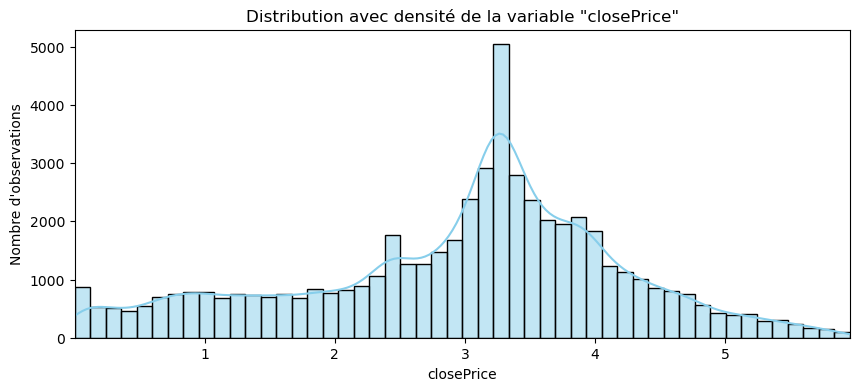

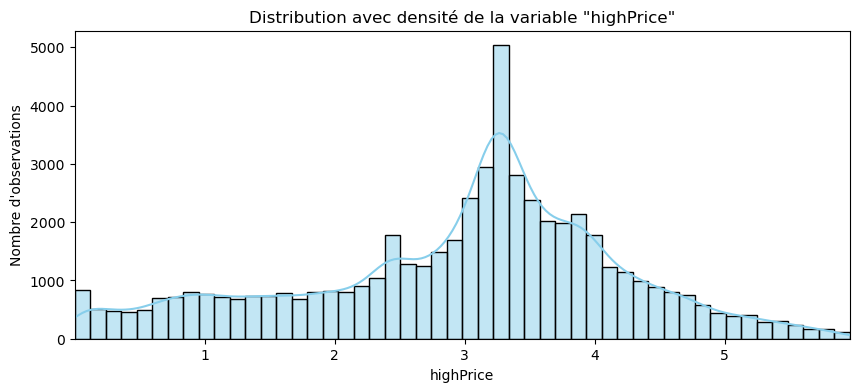

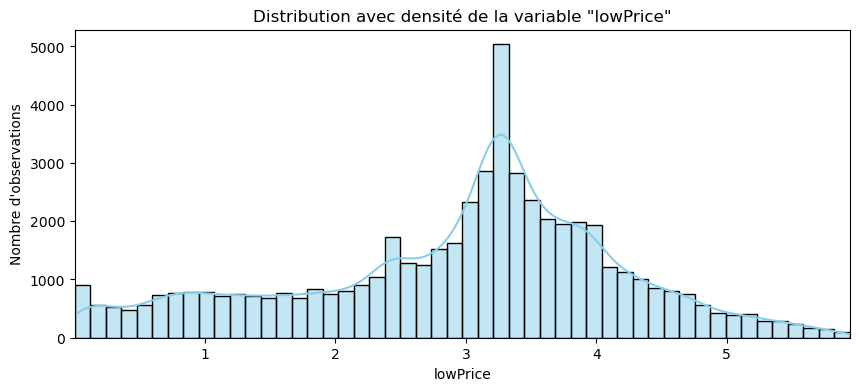

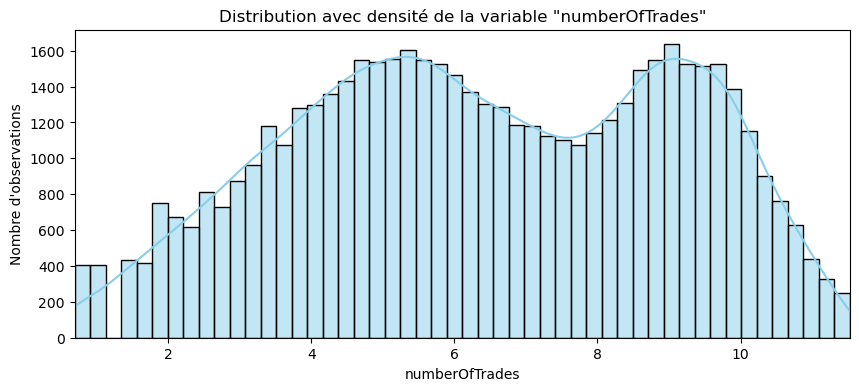

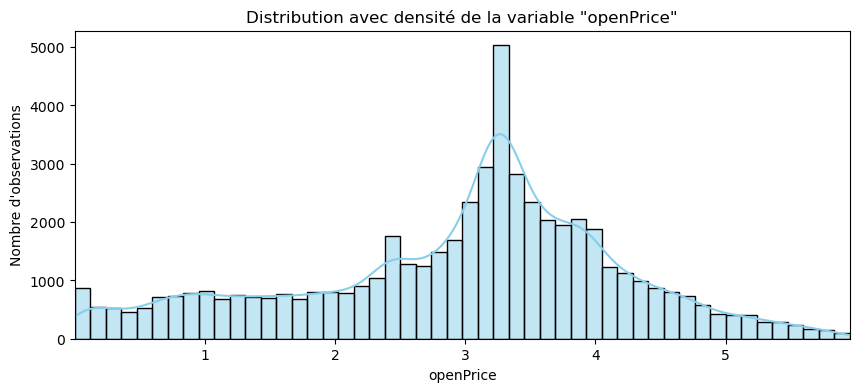

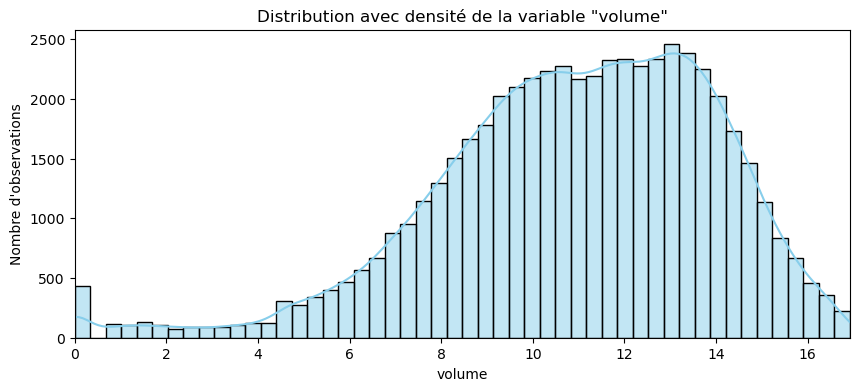

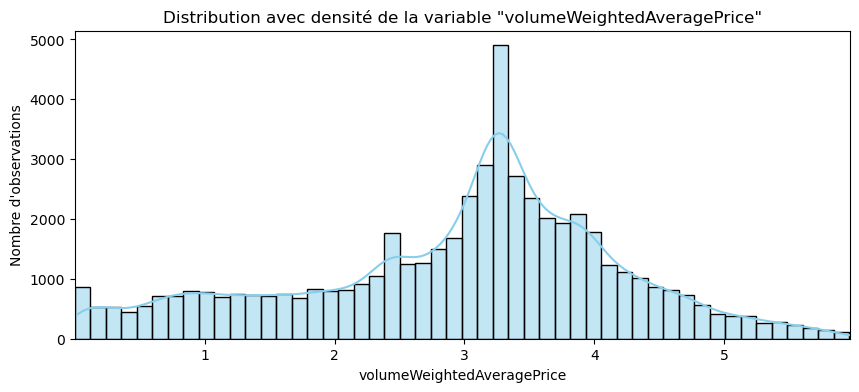

In [50]:
# G√©n√©ration de la distribution pour chaque variable num√©rique sur des graphiques s√©par√©s
variables = [
    'closePrice',
    'highPrice',
    'lowPrice',
    'numberOfTrades',
    'openPrice',
    'volume',
    'volumeWeightedAveragePrice'
]

for col in variables:
    data_log = np.log1p(df[col])
    
    # Calculer la limite sup√©rieure √† 99√®me percentile pour limiter les outliers
    x_max = data_log.quantile(0.99)
    
    plt.figure(figsize=(10, 4))
    sns.histplot(data_log[data_log <= x_max], bins=50, kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Distribution avec densit√© de la variable "{col}"')
    plt.xlabel(f'{col}')
    plt.ylabel("Nombre d'observations")
    plt.xlim(left=data_log.min(), right=x_max)  # Ajuste la limite x automatiquement
    plt.show()


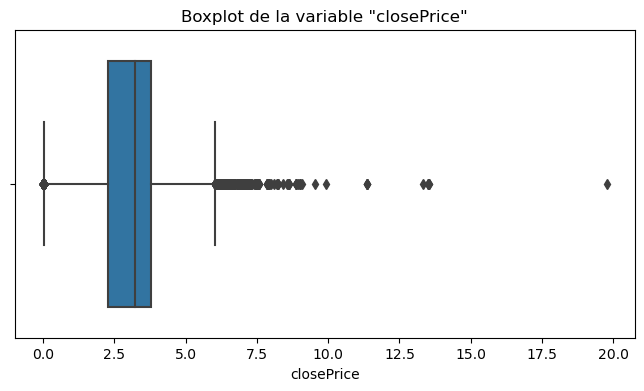

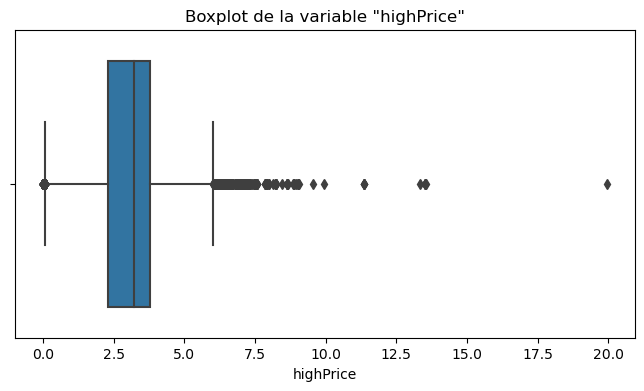

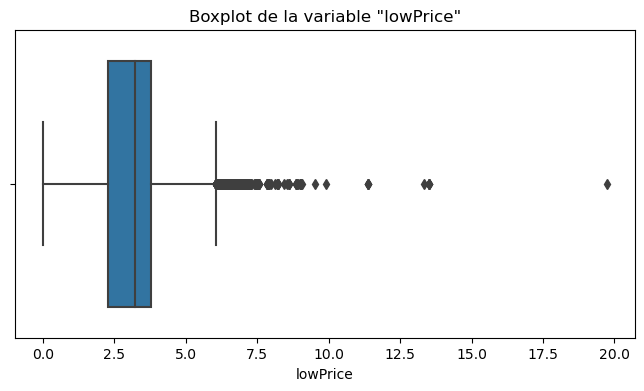

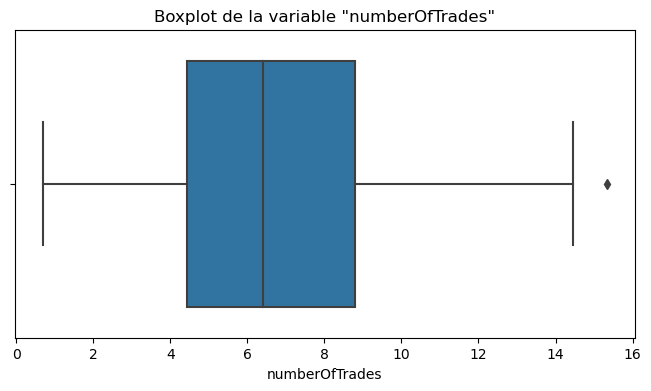

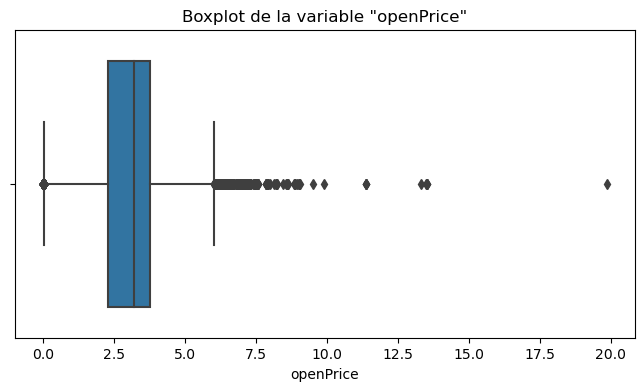

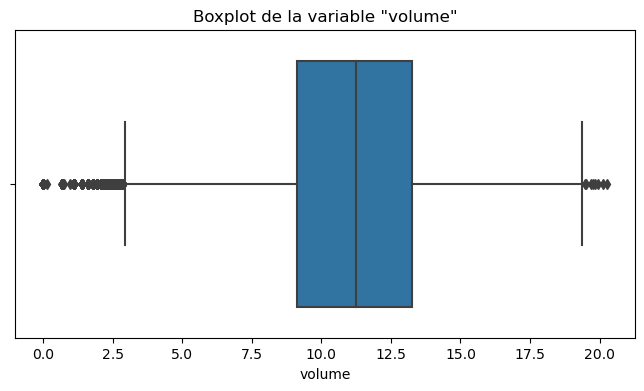

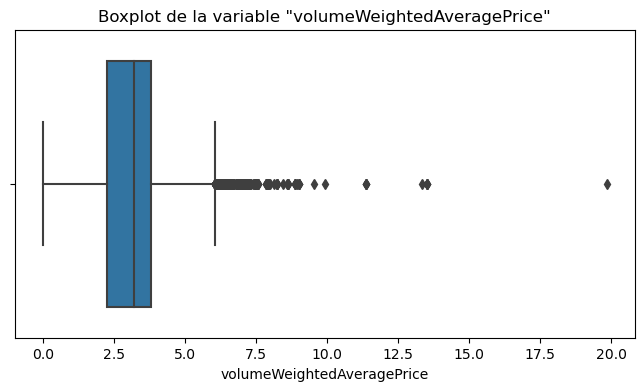

In [51]:
# G√©n√©ration des boxplots pour chaque variable num√©rique sur des graphiques s√©par√©s
variables = [
    'closePrice',
    'highPrice',
    'lowPrice',
    'numberOfTrades',
    'openPrice',
    'volume',
    'volumeWeightedAveragePrice'
]

for col in variables:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=np.log1p(df[col]))
    plt.title(f'Boxplot de la variable "{col}"')
    plt.xlabel(f'{col}')
    plt.show()


## Analyse des corr√©lations entre les variables

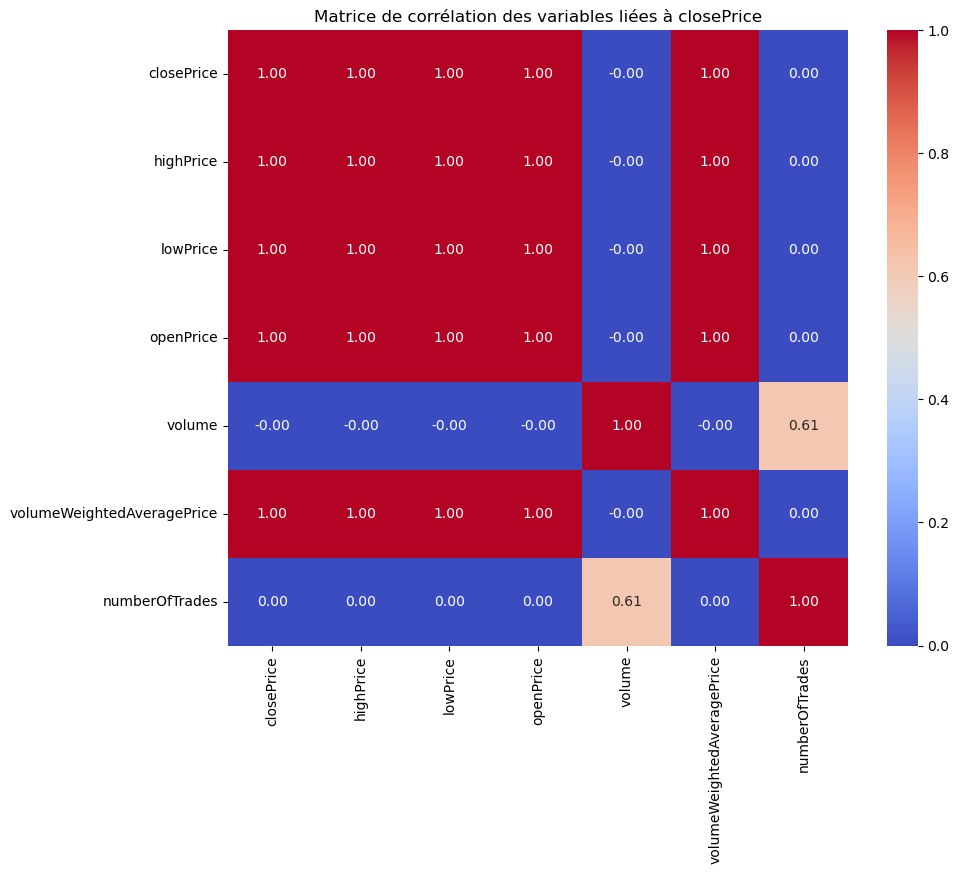

In [52]:
# S√©lection des variables num√©riques
num_vars = ['closePrice', 'highPrice', 'lowPrice', 'openPrice', 'volume', 'volumeWeightedAveragePrice', 'numberOfTrades']
df_num = df[num_vars]

# G√©n√©ration de la heatmap de corr√©lation
plt.figure(figsize=(10, 8))
sns.heatmap(df_num.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Matrice de corr√©lation des variables li√©es √† closePrice')
plt.show()

# Mod√©lisation

#### Suppression des valeurs aberrantes (outliers)

In [53]:
# Suppression des outliers
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = remove_outliers_iqr(df, ['volume', 'closePrice'])

### Normalisation des donn√©es

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['volume']] = scaler.fit_transform(df[['volume']])

# Choix des algorithmes de mod√©lisation


üìå Mod√®le : Linear Regression
‚ÑπÔ∏è RMSE r√©el : 1194.4432 | R¬≤ r√©el : -0.0012
‚úÖ RMSE Test : 1.2725
‚úÖ R¬≤ Test : 0.0135


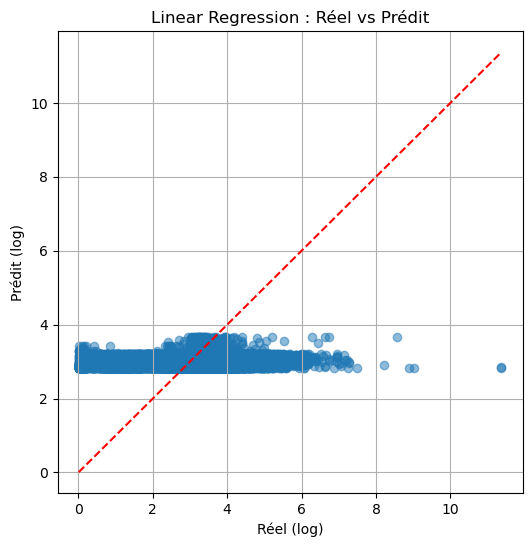


üìå Mod√®le : Lasso
‚ÑπÔ∏è RMSE r√©el : 1194.4368 | R¬≤ r√©el : -0.0012
‚úÖ RMSE Test : 1.2748
‚úÖ R¬≤ Test : 0.0098


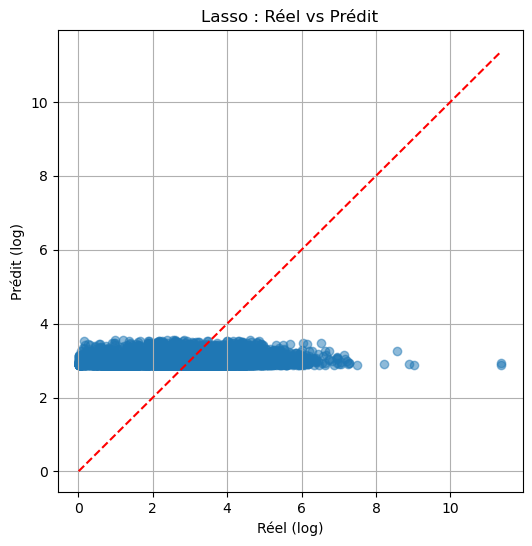


üìå Mod√®le : Ridge
‚ÑπÔ∏è RMSE r√©el : 1194.4411 | R¬≤ r√©el : -0.0012
‚úÖ RMSE Test : 1.2726
‚úÖ R¬≤ Test : 0.0132


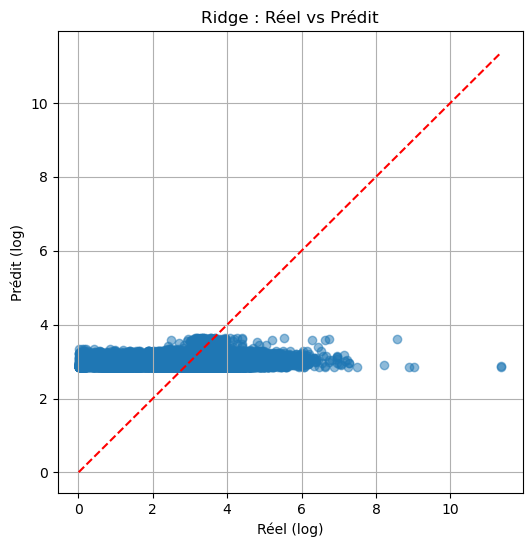


üìå Mod√®le : ElasticNet
‚ÑπÔ∏è RMSE r√©el : 1194.4368 | R¬≤ r√©el : -0.0012
‚úÖ RMSE Test : 1.2748
‚úÖ R¬≤ Test : 0.0099


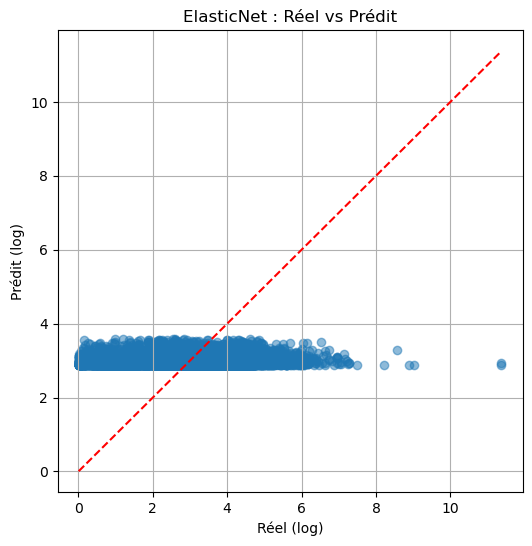


üìå Mod√®le : Decision Tree
‚ÑπÔ∏è RMSE r√©el : 1199.4013 | R¬≤ r√©el : -0.0095
‚úÖ RMSE Test : 1.7633
‚úÖ R¬≤ Test : -0.8945


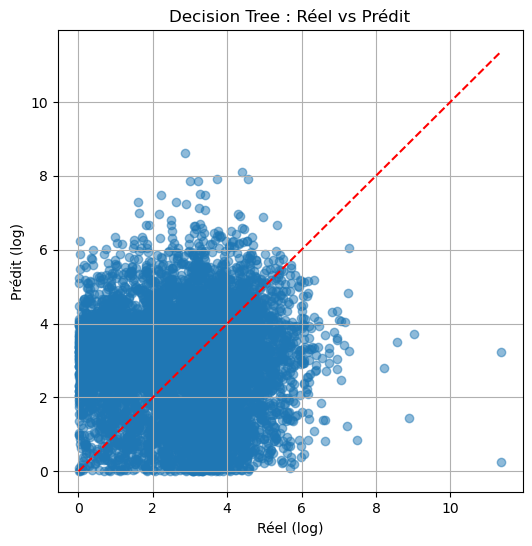


üìå Mod√®le : Random Forest
‚ÑπÔ∏è RMSE r√©el : 1194.8418 | R¬≤ r√©el : -0.0019
‚úÖ RMSE Test : 1.5284
‚úÖ R¬≤ Test : -0.4233


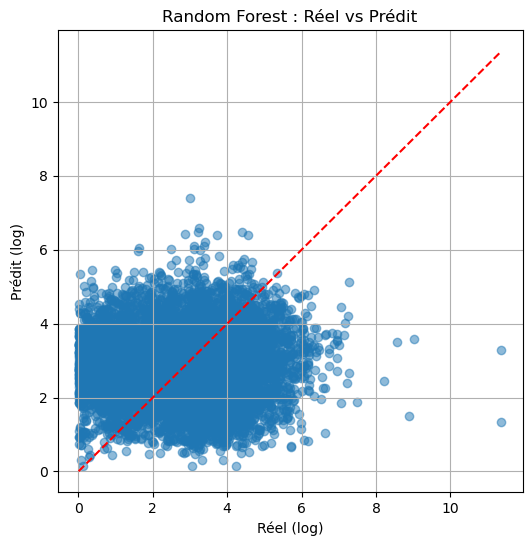


üìå Mod√®le : Gradient Boosting
‚ÑπÔ∏è RMSE r√©el : 1194.4184 | R¬≤ r√©el : -0.0011
‚úÖ RMSE Test : 1.2675
‚úÖ R¬≤ Test : 0.0211


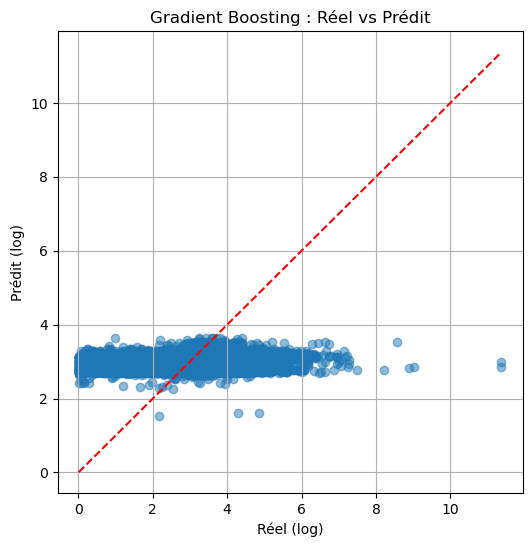


üìå Mod√®le : HistGradientBoosting
‚ÑπÔ∏è RMSE r√©el : 1194.4233 | R¬≤ r√©el : -0.0011
‚úÖ RMSE Test : 1.2689
‚úÖ R¬≤ Test : 0.0190


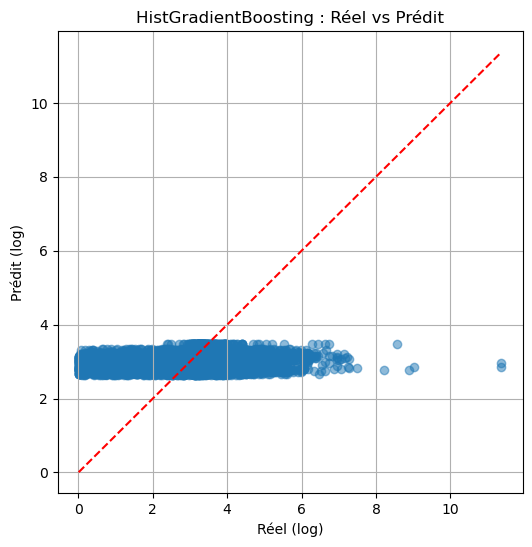


üìå Mod√®le : XGBoost
‚ÑπÔ∏è RMSE r√©el : 1194.4086 | R¬≤ r√©el : -0.0011
‚úÖ RMSE Test : 1.2709
‚úÖ R¬≤ Test : 0.0159


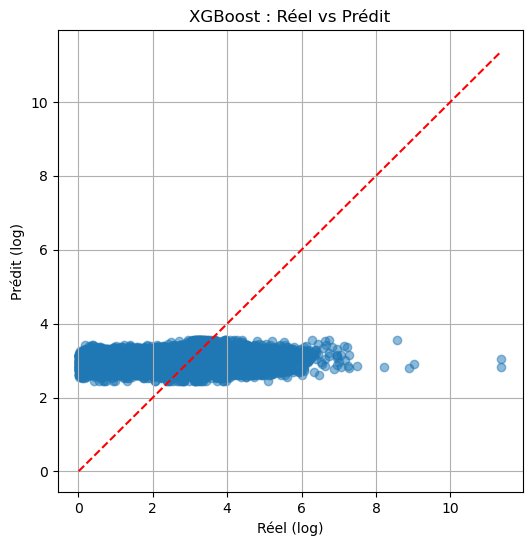


üìå Mod√®le : CatBoost
‚ÑπÔ∏è RMSE r√©el : 1194.4178 | R¬≤ r√©el : -0.0011
‚úÖ RMSE Test : 1.2700
‚úÖ R¬≤ Test : 0.0173


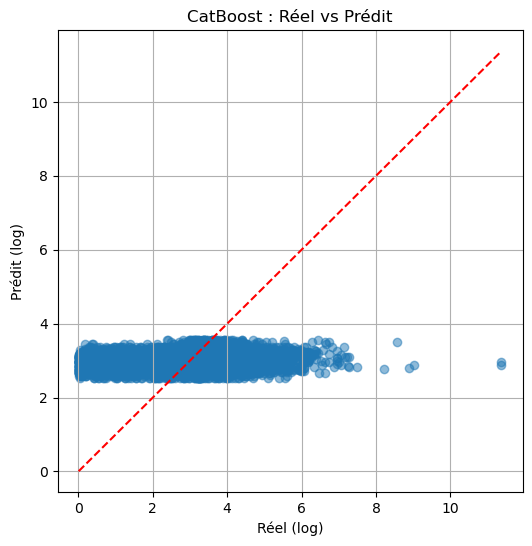


üìå Mod√®le : SVR (standardis√©)
‚ÑπÔ∏è RMSE r√©el : 1194.2871 | R¬≤ r√©el : -0.0009
‚úÖ R¬≤ CV : -0.0037 ¬± 0.0010
‚úÖ RMSE Test : 1.2806
‚úÖ R¬≤ Test : 0.0008

üìå Mod√®le : KNN (standardis√©)
‚ÑπÔ∏è RMSE r√©el : 1194.2564 | R¬≤ r√©el : -0.0009
‚úÖ R¬≤ CV : -0.1613 ¬± 0.0004
‚úÖ RMSE Test : 1.3851
‚úÖ R¬≤ Test : -0.1689

üìå Mod√®le : MLP (standardis√©)
‚ÑπÔ∏è RMSE r√©el : 1194.4327 | R¬≤ r√©el : -0.0012
‚úÖ R¬≤ CV : 0.0175 ¬± 0.0007
‚úÖ RMSE Test : 1.2700
‚úÖ R¬≤ Test : 0.0173

üìä R√©sultats finaux :
                  Mod√®le   R¬≤ CV  STD CV  RMSE Test  R¬≤ Test
6      Gradient Boosting  0.0198  0.0002     1.2675   0.0211
7   HistGradientBoosting  0.0180  0.0002     1.2689   0.0190
9               CatBoost  0.0145  0.0007     1.2700   0.0173
12                   MLP  0.0175  0.0007     1.2700   0.0173
8                XGBoost  0.0128  0.0016     1.2709   0.0159
0      Linear Regression  0.0136  0.0004     1.2725   0.0135
2                  Ridge  0.0129  0.0005     1.2726   0

C:\Users\KABRE\AppData\Local\Temp\ipykernel_19440\773098288.py:149: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\Users\KABRE\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


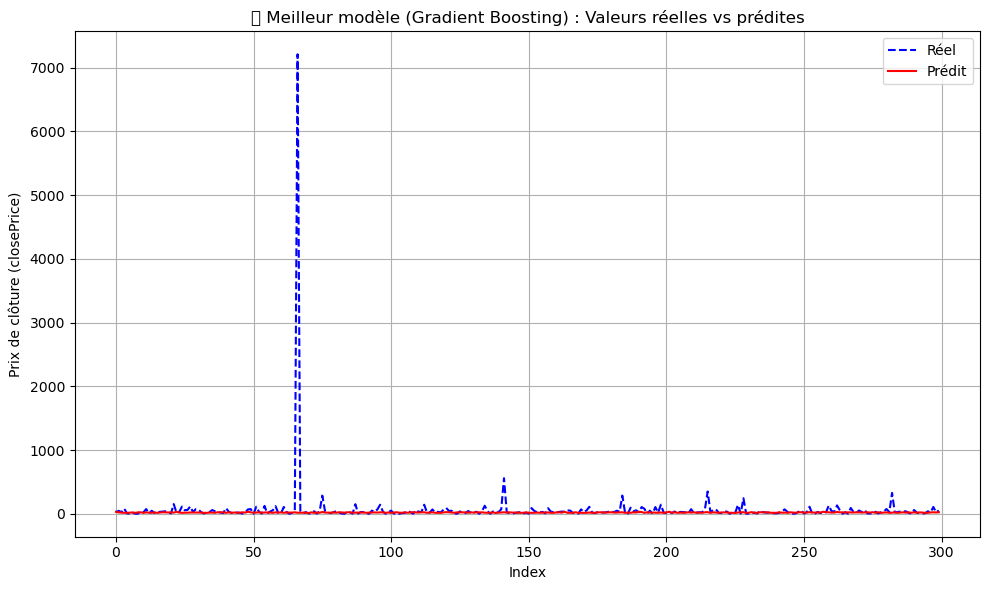

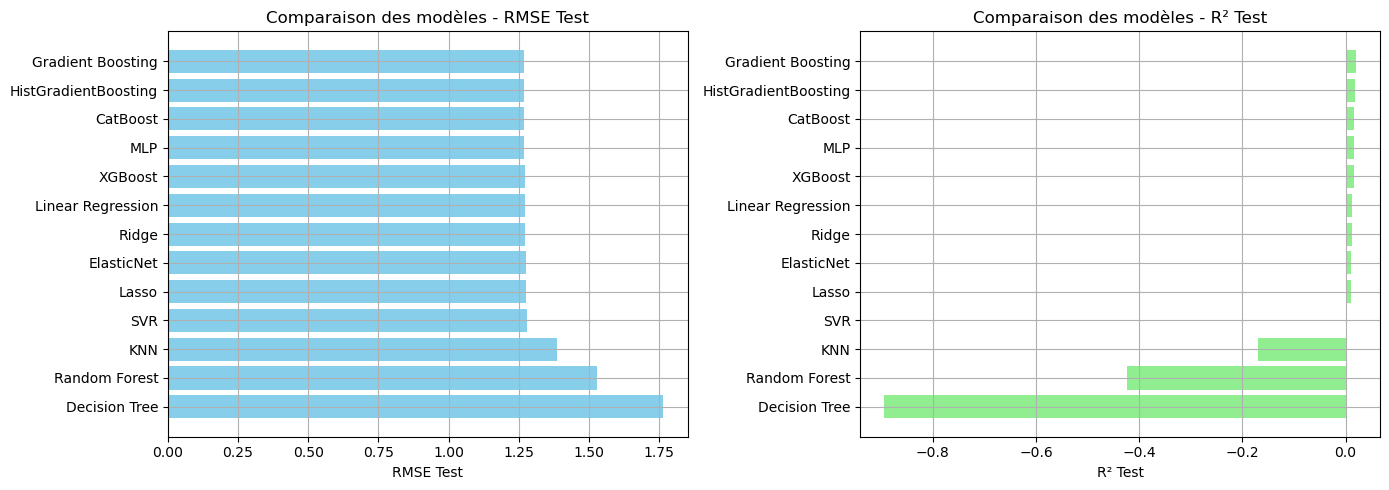

In [55]:
df.dropna(subset=['volume', 'closePrice'], inplace=True)
scaler = StandardScaler()
df_filtered = df[(df['volume'] > df['volume'].quantile(0.01)) & 
                 (df['volume'] < df['volume'].quantile(0.99))].copy()

df_filtered['log_volume'] = np.log1p(df_filtered['volume'])
df_filtered['log_closePrice'] = np.log1p(df_filtered['closePrice'])

df_filtered['log_volume_sq'] = df_filtered['log_volume'] ** 2
df_filtered['log_volume_cub'] = df_filtered['log_volume'] ** 3
df_filtered['sqrt_log_volume'] = np.sqrt(df_filtered['log_volume'])

X = df_filtered[['log_volume', 'log_volume_sq', 'log_volume_cub', 'sqrt_log_volume']]
y = df_filtered['log_closePrice']

df_model = pd.concat([X, y], axis=1).dropna()
X = df_model[X.columns]
y = df_model[y.name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ======================================
# Fonctions
# ======================================

def evaluate_model(model, X, y):
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    return scores.mean(), scores.std()

def test_metrics(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_log = r2_score(y_test, y_pred)

    y_test_real = np.expm1(y_test)
    y_pred_real = np.expm1(y_pred)
    rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    r2_real = r2_score(y_test_real, y_pred_real)
    
    print(f"‚ÑπÔ∏è RMSE r√©el : {rmse_real:.4f} | R¬≤ r√©el : {r2_real:.4f}")
    
    return rmse_log, r2_log, y_pred, y_test_real, y_pred_real

def plot_predictions(y_test, y_pred, model_name):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('R√©el (log)')
    plt.ylabel('Pr√©dit (log)')
    plt.title(f'{model_name} : R√©el vs Pr√©dit')
    plt.grid(True)
    plt.show()

# ======================================
# Mod√®les
# ======================================

models_unscaled = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1),
    "Ridge": Ridge(alpha=1.0),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
}

models_scaled = {
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "MLP": MLPRegressor(random_state=42, max_iter=500)
}

# ======================================
# √âvaluation
# ======================================

results = []
predictions_dict = {}  # ‚úÖ Ajout√© ici

for name, model in models_unscaled.items():
    print(f"\nüìå Mod√®le : {name}")
    try:
        r2_cv, std_cv = evaluate_model(model, X, y)
        rmse_test, r2_test, y_pred, y_real, y_pred_real = test_metrics(model, X_train, X_test, y_train, y_test)
        print(f"‚úÖ RMSE Test : {rmse_test:.4f}")
        print(f"‚úÖ R¬≤ Test : {r2_test:.4f}")
        plot_predictions(y_test, y_pred, name)
        results.append({
            "Mod√®le": name,
            "R¬≤ CV": round(r2_cv, 4),
            "STD CV": round(std_cv, 4),
            "RMSE Test": round(rmse_test, 4),
            "R¬≤ Test": round(r2_test, 4)
        })
        predictions_dict[name] = (y_real, y_pred_real)
    except Exception as e:
        print(f"‚ö†Ô∏è Erreur avec {name} : {e}")

for name, model in models_scaled.items():
    print(f"\nüìå Mod√®le : {name} (standardis√©)")
    try:
        r2_cv, std_cv = evaluate_model(model, scaler.transform(X), y)
        rmse_test, r2_test, y_pred, y_real, y_pred_real = test_metrics(model, X_train_scaled, X_test_scaled, y_train, y_test)
        print(f"‚úÖ R¬≤ CV : {r2_cv:.4f} ¬± {std_cv:.4f}")
        print(f"‚úÖ RMSE Test : {rmse_test:.4f}")
        print(f"‚úÖ R¬≤ Test : {r2_test:.4f}")
        results.append({
            "Mod√®le": name,
            "R¬≤ CV": round(r2_cv, 4),
            "STD CV": round(std_cv, 4),
            "RMSE Test": round(rmse_test, 4),
            "R¬≤ Test": round(r2_test, 4)
        })
        predictions_dict[name] = (y_real, y_pred_real)
    except Exception as e:
        print(f"‚ö†Ô∏è Erreur avec {name} (standardis√©) : {e}")

# ==============================
# R√©sultats & Visualisation
# ==============================

results_df = pd.DataFrame(results).sort_values(by="R¬≤ Test", ascending=False)
print("\nüìä R√©sultats finaux :")
print(results_df)

# üîç Comparatif r√©el vs pr√©dit du meilleur mod√®le
best_model = results_df.iloc[0]['Mod√®le']
best_y_real, best_y_pred = predictions_dict[best_model]

plt.figure(figsize=(10, 6))
plt.plot(best_y_real.values[:300], label='R√©el', color='blue', linestyle='--')
plt.plot(best_y_pred[:300], label='Pr√©dit', color='red')
plt.title(f"üîç Meilleur mod√®le ({best_model}) : Valeurs r√©elles vs pr√©dites")
plt.xlabel("Index")
plt.ylabel("Prix de cl√¥ture (closePrice)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Barplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

results_df_sorted = results_df.sort_values("RMSE Test")
axes[0].barh(results_df_sorted["Mod√®le"], results_df_sorted["RMSE Test"], color='skyblue')
axes[0].set_xlabel("RMSE Test")
axes[0].set_title("Comparaison des mod√®les - RMSE Test")
axes[0].invert_yaxis()
axes[0].grid(True)

results_df_sorted = results_df.sort_values("R¬≤ Test", ascending=False)
axes[1].barh(results_df_sorted["Mod√®le"], results_df_sorted["R¬≤ Test"], color='lightgreen')
axes[1].set_xlabel("R¬≤ Test")
axes[1].set_title("Comparaison des mod√®les - R¬≤ Test")
axes[1].invert_yaxis()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# meilleur algorithme : Gradient Boosting 


üìå Mod√®le : Gradient Boosting
‚úÖ R¬≤ CV       : 0.0198 ¬± 0.0002
‚úÖ RMSE  : 1194.4184
‚úÖ MAE   : 49.7503
‚úÖ R¬≤    : 0.0211


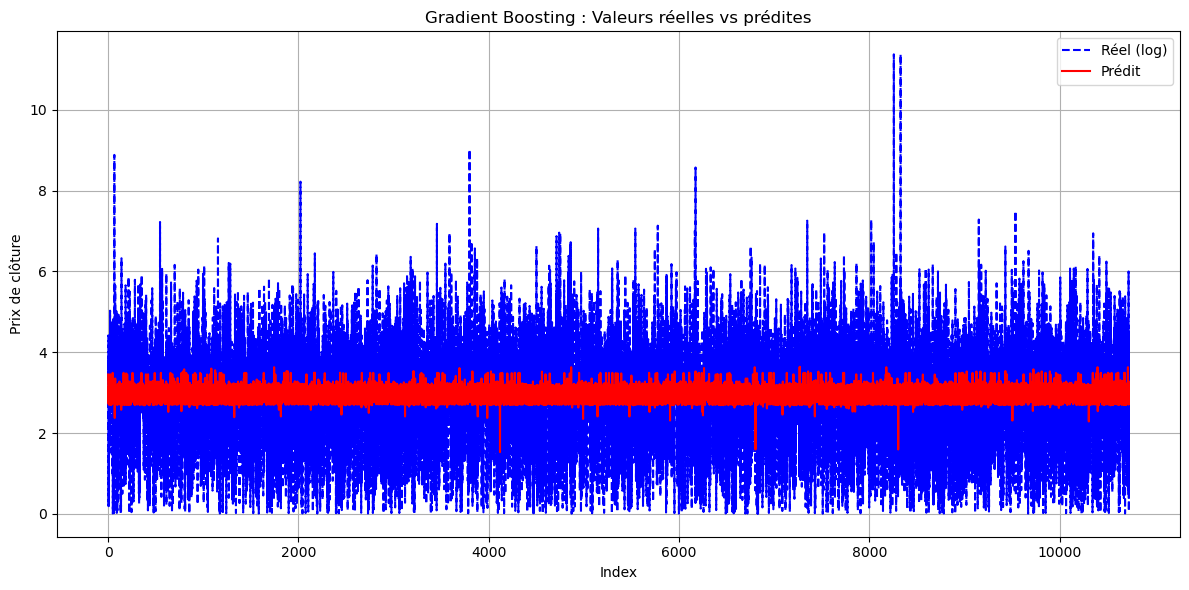

In [105]:
df.dropna(subset=['volume', 'closePrice'], inplace=True)

df_filtered = df[(df['volume'] > df['volume'].quantile(0.01)) & 
                 (df['volume'] < df['volume'].quantile(0.99))].copy()

df_filtered['log_volume'] = np.log1p(df_filtered['volume'])
df_filtered['log_closePrice'] = np.log1p(df_filtered['closePrice'])

df_filtered['log_volume_sq'] = df_filtered['log_volume'] ** 2
df_filtered['log_volume_cub'] = df_filtered['log_volume'] ** 3
df_filtered['sqrt_log_volume'] = np.sqrt(df_filtered['log_volume'])

X = df_filtered[['log_volume', 'log_volume_sq', 'log_volume_cub', 'sqrt_log_volume']]
y = df_filtered['log_closePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ======================================
# Fonctions utiles
# ======================================

def evaluate_model(model, X, y):
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    return scores.mean(), scores.std()

def test_metrics(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_log = r2_score(y_test, y_pred)
    mae_log = mean_absolute_error(y_test, y_pred)

    y_test_real = np.expm1(y_test)
    y_pred_real = np.expm1(y_pred)

    rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    r2_real = r2_score(y_test_real, y_pred_real)
    mae_real = mean_absolute_error(y_test_real, y_pred_real)

    return rmse_log, r2_log, mae_log, rmse_real, r2_real, mae_real, y_pred, y_test_real, y_pred_real

# ======================================
# Mod√®le Gradient Boosting uniquement
# ======================================

model_name = "Gradient Boosting"
model = GradientBoostingRegressor(random_state=42)

print(f"\nüìå Mod√®le : {model_name}")

r2_cv, std_cv = evaluate_model(model, X, y)
rmse_log, r2_log, mae_log, rmse_real, r2_real, mae_real, y_pred, y_real, y_pred_real = test_metrics(
    model, X_train, X_test, y_train, y_test
)

print(f"‚úÖ R¬≤ CV       : {r2_cv:.4f} ¬± {std_cv:.4f}")
print(f"‚úÖ RMSE  : {rmse_real:.4f}")
print(f"‚úÖ MAE   : {mae_real:.4f}")
print(f"‚úÖ R¬≤    : {r2_log:.4f}")


# ==============================
# Visualisation : r√©el vs pr√©dit
# ==============================
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='R√©el (log)', color='blue', linestyle='--')
plt.plot(pd.Series(y_pred).reset_index(drop=True), label='Pr√©dit', color='red')
plt.title(f"{model_name} : Valeurs r√©elles vs pr√©dites")
plt.xlabel("Index")
plt.ylabel("Prix de cl√¥ture")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Vers un meilleur mod√®le pr√©dictif de closePrice 


üìå Mod√®le : Gradient Boosting
‚úÖ R¬≤ CV       : 0.9299 ¬± 0.0018
‚úÖ RMSE  : 0.3339
‚úÖ MAE   : 0.2529
‚úÖ R¬≤    : 0.9321


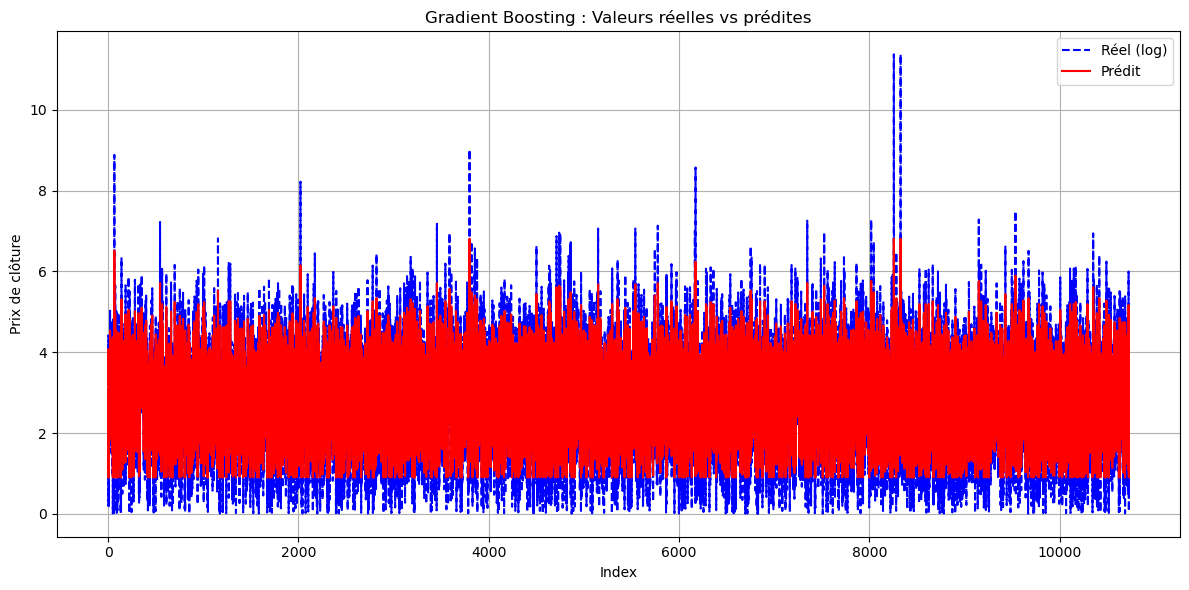

In [120]:
# Transformation logarithmique
df_filtered['log_closePrice'] = np.log1p(df_filtered['closePrice'])

# S√©lection des features
features = ['volume', 'highPrice', 'lowPrice', 'openPrice']
target = 'log_closePrice'

X = df_filtered[features]
y = df_filtered[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ======================================
# Fonctions utiles
# ======================================

def evaluate_model(model, X, y):
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    return scores.mean(), scores.std()

def test_metrics(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_log = r2_score(y_test, y_pred)
    mae_log = mean_absolute_error(y_test, y_pred)

    y_test_real = np.expm1(y_test)
    y_pred_real = np.expm1(y_pred)

    rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    r2_real = r2_score(y_test_real, y_pred_real)
    mae_real = mean_absolute_error(y_test_real, y_pred_real)

    return rmse_log, r2_log, mae_log, rmse_real, r2_real, mae_real, y_pred, y_test_real, y_pred_real

# ======================================
# Mod√®le Gradient Boosting uniquement
# ======================================

model_name = "Gradient Boosting"

model = GradientBoostingRegressor(
    n_estimators=70,
    learning_rate=0.02,
    max_depth=3,
    min_samples_split=15,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42
)



print(f"\nüìå Mod√®le : {model_name}")

r2_cv, std_cv = evaluate_model(model, X, y)
rmse_log, r2_log, mae_log, rmse_real, r2_real, mae_real, y_pred, y_real, y_pred_real = test_metrics(
    model, X_train, X_test, y_train, y_test
)

print(f"‚úÖ R¬≤ CV       : {r2_cv:.4f} ¬± {std_cv:.4f}")
print(f"‚úÖ RMSE  : {rmse_log:.4f}")
print(f"‚úÖ MAE   : {mae_log:.4f}")
print(f"‚úÖ R¬≤    : {r2_log:.4f}")


# ==============================
# Visualisation : r√©el vs pr√©dit
# ==============================
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='R√©el (log)', color='blue', linestyle='--')
plt.plot(pd.Series(y_pred).reset_index(drop=True), label='Pr√©dit', color='red')
plt.title(f"{model_name} : Valeurs r√©elles vs pr√©dites")
plt.xlabel("Index")
plt.ylabel("Prix de cl√¥ture")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Sauvegardons le mod√®le entra√Æn√©

In [58]:
import joblib
import os

# Cr√©er le dossier s'il n'existe pas
os.makedirs("models", exist_ok=True)

# Sauvegarde du mod√®le entra√Æn√©
joblib.dump(model, "models/gradient_boosting_model.pkl")
print("‚úÖ Mod√®le sauvegard√© sous : models/gradient_boosting_model.pkl")


‚úÖ Mod√®le sauvegard√© sous : models/gradient_boosting_model.pkl
